In [1]:
#####Latent Variable timestamp allocation#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import math
from scipy import sparse
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize
import seaborn as sns
import time

#np.random.seed(98537)

In [2]:
##多項分布の乱数を生成する関数
def rmnom(pr, n, k, no):
    z_id = np.argmax((np.cumsum(pr, axis=1) > np.random.rand(n).reshape(n, 1)), axis=1)
    Z = sparse.coo_matrix((np.repeat(1, n), (no, np.array(z_id))), shape=(n, k))   #スパース行列の設定
    return Z

In [3]:
####データの発生####
##データの設定
k = 7
week = 7
hour = 24
hh = 5000
pt = np.random.poisson(np.random.gamma(20, 1/0.25, hh), hh)
hhpt = np.sum(pt)

In [4]:
##IDとインデックスの設定
#IDの設定
user_id = np.repeat(np.arange(hh), pt)
pt_id = np.array(list(itertools.chain(*[np.array(range(pt[i]), dtype="int") for i in range(hh)])))

#インデックスの設定
index = np.arange(hhpt)
user_list = [i for i in range(hh)]
user_vec = [i for i in range(hh)]
for i in range(hh):
    user_list[i] = index[user_id==i]
    user_vec[i] = np.repeat(1, pt[i])

In [5]:
##説明変数の生成
k1 = 4; k2 = 5; k3 = 6
x1 = np.array(np.random.random(hhpt*k1)).reshape((hhpt, k1))
x2 = np.zeros((hhpt, k2))
for j in range(k2):
    prob = np.random.uniform(0.25, 0.55, 1)
    x2[:, j] = np.random.binomial(1, prob, hhpt)
x3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k3), 1).reshape(k3), hhpt)
x3 = np.delete(x3, np.argmin(np.sum(x3, axis=0)), axis=1)   #冗長な変数の削除
x = np.concatenate((np.repeat(1, hhpt)[:, np.newaxis], x1, x2, x3), axis=1)
col = x.shape[1]

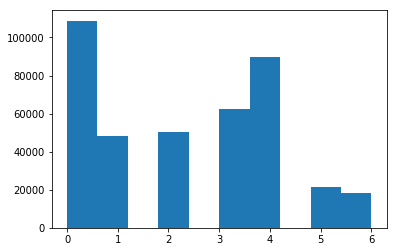

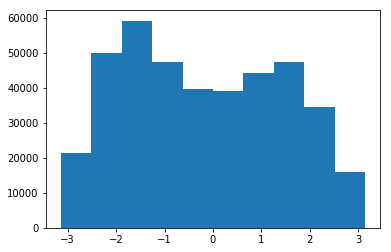

In [6]:
##応答変数を生成
#モデルパラメータを設定
theta = np.random.dirichlet(np.repeat(0.2, k), hh)
phi = np.random.dirichlet(np.repeat(0.25, week), k)
beta = np.append(np.random.uniform(-1.25, 1.75, k), np.random.normal(0, 0.75, k*(col-1))).reshape(k, col, order="F")
kappa = np.random.uniform(2.0, 7.5, k)
thetat = theta.copy(); phit = phi.copy(); betat = beta.copy(); kappat = kappa.copy()

#トピックを生成
Z = np.array(rmnom(theta[user_id, ], hhpt, k, np.arange(hhpt)).todense(), dtype="int16")
z_vec = np.dot(Z, np.arange(k))

#トピックからtimestampを生成
W = np.array(rmnom(phi[z_vec, ], hhpt, week, np.arange(hhpt)).todense(), dtype="int16")
w = np.dot(W, np.arange(week))
mu = 2*np.arctan(np.dot(x * beta[z_vec, ], np.repeat(1, col)))
y = np.random.vonmises(mu, kappa[z_vec], hhpt)
plt.hist(w); plt.show()
plt.hist(y); plt.show()

In [7]:
#週割当のインデックスを作成
week_list = [j for j in range(week)]
week_vec = [j for j in range(week)]
for j in range(week):
    week_list[j] = np.array(np.where(w==j)[0], dtype="int")
    week_vec[j] = np.repeat(1, week_list[j].shape[0])

In [8]:
####EMアルゴリズムでLatent Variable timestamp allocationを推定####
##Von Mises Regression modelのパラメータを推定するための関数
#完全データのVon Mises modelの対数尤度関数
def cll(alpha, z, y, x, hhpt, index1, index2):
    
    #パラメータの設定
    beta = alpha[index1].reshape(k, col).T
    kappa = np.exp(alpha[index2])

    #潜在変数での重み付き確率
    mu = 2*np.arctan(np.dot(x, beta))
    Lho = z * np.exp(kappa*np.cos(y.reshape(hhpt, 1) - mu)) / (2*np.pi*scipy.special.i0(kappa))
    LL = -np.sum(np.log(np.dot(Lho, np.repeat(1, k))))
    return LL 

In [9]:
#完全データのVon Mises modelの対数尤度関数の勾配ベクトル
def dll(alpha, z, y, x, hhpt, index1, index2):
    
    #パラメータの設定
    beta = alpha[index1].reshape(k, col).T
    kappa = np.exp(alpha[index2])
    
    #リンク関数と期待値を設定
    h = 1e-4
    beta_mu = np.dot(x, beta)
    mu = 2*np.arctan(beta_mu)
    
    #回帰ベクトルと分散パラメータの対数尤度の勾配ベクトル
    LLd1 = np.zeros((k, col)); LLd2 = np.repeat(0, k)
    for j in range(k):
        kappa1 = kappa.copy(); kappa2 = kappa.copy()
        kappa1[j] += h; kappa2[j] -= h
        z_vec = z[:, j].reshape(hhpt, 1)
        LLd1[j, ] = np.sum(z_vec * np.sin(y - mu[:, j]).reshape(hhpt, 1) * 
                           (2 * (x / (1 + np.power(beta_mu[:, j].reshape(hhpt, 1), 2)))), axis=0)
        LLd2[j] = (LL_kappa(kappa1, z, mu, y, x, hhpt) - LL_kappa(kappa2, z, mu, y, x, hhpt)) / (2*h)

    #勾配ベクトルの戻り値
    LLd = -np.append(LLd1.reshape(-1), LLd2)
    return LLd 

In [10]:
#分散パラメータの推定用の対数尤度関数
def LL_kappa(kappa, z, mu, y, x, hhpt):
    Lho = np.dot(z * np.exp(kappa*np.cos(y.reshape(hhpt, 1) - mu)) / (2*np.pi*scipy.special.i0(kappa)), np.repeat(1, k))
    LL = np.sum(np.log(Lho))
    return LL 

In [11]:
##観測データの対数尤度と潜在変数zを計算する関数
def LLobz(theta, phi, beta, kappa, y, w, x, user_id, k, hhpt):
    #潜在変数の条件付き尤度
    Lho1 = np.zeros((hhpt, k))
    mu = 2*np.arctan(np.dot(x, beta.T))   #リンク関数
    for j in range(k):
        Lho1[:, j] = np.exp(kappa[j]*np.cos(y - mu[:, j])) / (2*np.pi*scipy.special.i0(kappa[j]))
    Lho2 = phi.T[w, ]
    
    #潜在変数の割当確率
    Lho = theta[user_id, ] * Lho1 * Lho2
    z = Lho / np.dot(Lho, np.repeat(1, k)).reshape(hhpt, 1)
    LL = np.sum(np.log(np.dot(Lho, np.repeat(1, k))))
    return z, LL

In [12]:
##EMアルゴリズムの設定
iter = 0
rp = 200   #最大繰り返し数
LL = -1000000000   #対数尤度の初期値
dl = 100   #EMアルゴリズムの対数尤度の差の初期値
tol = 1.0
maxit = 20   #準ニュートン法のステップ数

In [13]:
##パラメータの真値
#トピック分布の真意
theta = thetat

#モデルパラメータの真値
index1 = np.arange(col*k); index2 = np.max(index1)+np.arange(k)+1
phi = phit
beta = betat
kappa = np.log(kappat)
alpha = np.append(beta.reshape(-1), kappa)

#真値での対数尤度
LLbest = LLobz(thetat, phit, betat, kappat, y, w, x, user_id, k, hhpt)[1]
cllbest = -cll(alpha, Z, y, x, hhpt, index1, index2)

In [14]:
##初期値の設定
#トピック分布の初期値
theta = np.random.dirichlet(np.repeat(2.5, k), hh)

#モデルパラメータの初期値
index1 = np.arange(col*k); index2 = np.max(index1)+np.arange(k)+1
phi = np.random.dirichlet(np.repeat(2.5, week), k)
beta = np.append(np.random.uniform(-1.0, 1.0, k), np.random.normal(0, 0.5, k*(col-1))).reshape(k, col, order="F")
kappa = np.log(np.random.uniform(0, 1.0, k))
alpha = np.append(beta.reshape(-1), kappa)

In [15]:
#観測データの対数尤度と潜在変数
oll = LLobz(theta, phi, beta, kappa, y, w, x, user_id, k, hhpt)
zpt = oll[0]
LL1 = oll[1]
    
#対数尤度を表示
print(np.array([LL1, LLbest]))
print(np.array([-cll(alpha, zpt, y, x, hhpt, index1, index2), cllbest]))

[-1581642.38469185  -989809.86845064]
[-766333.60457304 -304803.27797348]


In [16]:
##EMアルゴリズムでパラメータを推定
while abs(dl) >= tol:
    
    ##完全データの対数尤度を最大化
    #準ニュートン法で回帰パラメータを最適化
    res = optimize.minimize(cll, alpha, jac=dll, method='BFGS', args=(zpt, y, x, hhpt, index1, index2),
                            options={'gtol': 1.0, "disp":False})
    alpha = res.x; beta = alpha[index1].reshape(k, col); kappa = np.exp(alpha[index2])
    
    #week割当のパラメータを最適化
    week_par = np.zeros((k, week))
    for j in range(week):
        week_par[:, j] = np.dot(week_vec[j], zpt[week_list[j], ])
    phi = week_par / np.sum(week_par, axis=1).reshape(k, 1)
    
    #トピック割当確率を更新
    for i in range(hh):
        topic_par = np.dot(user_vec[i], zpt[user_list[i], ])
        theta[i, ] = topic_par / np.sum(topic_par)

    #Eステップで対数尤度の期待値と潜在変数を更新
    oll = LLobz(theta, phi, beta, kappa, y, w, x, user_id, k, hhpt)
    zpt = oll[0]
    LL = oll[1]

    #EMアルゴリズムのパラメータを更新
    iter = iter + 1
    dl = LL - LL1
    LL1 = LL
    print(np.array([LL, LLbest]))

[-1426974.29645285  -989809.86845064]
[-1395565.89802011  -989809.86845064]
[-1365240.12824507  -989809.86845064]
[-1333579.02280459  -989809.86845064]
[-1315094.94025394  -989809.86845064]
[-1300323.9336712   -989809.86845064]
[-1275555.33147512  -989809.86845064]
[-1252016.63709575  -989809.86845064]
[-1237808.05897397  -989809.86845064]
[-1226352.41497169  -989809.86845064]
[-1218208.97980521  -989809.86845064]
[-1211506.78139189  -989809.86845064]
[-1205585.48471155  -989809.86845064]
[-1198390.49614287  -989809.86845064]
[-1189134.73233181  -989809.86845064]
[-1184391.97122464  -989809.86845064]
[-1179113.88134316  -989809.86845064]
[-1176294.40538999  -989809.86845064]
[-1174065.51989772  -989809.86845064]
[-1172176.36771064  -989809.86845064]
[-1168368.30961898  -989809.86845064]
[-1166235.89098675  -989809.86845064]
[-1164409.60992865  -989809.86845064]
[-1162792.12295207  -989809.86845064]
[-1161329.82504911  -989809.86845064]
[-1159974.94006777  -989809.86845064]
[-1156493.40